# Bayesian (hierarchical) modelling in practice

## or: How much chocolate do I need to eat to be more productive

In this tutorial we will explore principles of Bayesian modelling in practice, starting from some simple data and going all the way to a full Bayesian hierarchical modelling.

The problem: I don't drink coffee. This is clearly not great for my productivity, so I need to figure out an alternative. I've been wondering if maybe chocolate would make me more productive, so I've taken some data (not really, but I kind of wish I had!). I'm also curious how *much* chocolate I ought to eat in order to be more productive. Too little, and it won't have an effect. Too much, and I might be too ill to get anything done. 

Let's see what we can find out!

### Imports + Packages

You might not have all the packages you need in order to follow this notebook. If you don't, here's some code that might help you install it. If you don't use `pip` to manage your packages (e.g. because you use Anaconda), you might want to do this in a command line instead, and then restart the notebook.

If you're working in Colab, definitely remove the commenting from the last three.

In [1]:
#!pip install seaborn
#!pip install pandas
#!pip install emcee
#!pip install corner
#!pip install pymc3

Now we can import the necessary packages:

In [2]:
# If you're running in Colab, comment out this line below
%matplotlib notebook

# Imports
import matplotlib.pyplot as plt
import seaborn as sns

# some style choices
sns.set_style("whitegrid")
sns.set_context("talk")

import copy

import numpy as np
import pandas as pd

import scipy.optimize
import scipy.stats

import emcee
import corner

If you're in Colab, you'll want to clone the github repo and move into it in order to load the data:

In [3]:
#!git clone https://github.com/dhuppenkothen/cargese2018_tutorials.git
#%cd cargese2018_tutorials/tutorial1/


In either case, you should now be able to read in the data:

In [4]:
df = pd.read_csv("chocolate_productivity_daniela.csv", index_col=0)

If you've never used pandas `DataFrame`s before, they might take some time getting used to. One useful thing you can do is use the `head` method to take a look at the data:

In [5]:
df.head()

,grams,prod,prod_err,name,name_id,true_amp,true_x0,true_gamma
0,88.497809,0.462267,1.0,Daniela,0,41.025738,24.723232,11.565747
1,125.566665,-0.202525,1.0,Daniela,0,41.025738,24.723232,11.565747
2,104.670091,1.400663,1.0,Daniela,0,41.025738,24.723232,11.565747
3,120.420426,2.775350,1.0,Daniela,0,41.025738,24.723232,11.565747
4,16.082262,11.975859,1.0,Daniela,0,41.025738,24.723232,11.565747


Our data here is the grams that I ate in a day (in the column `grams`), and the productivity of that day (`prod`) as measured in lines of code or text in a paper. Because I suck at counting, there's some uncertainty in that number called `prod_err`. 

Let's plot what the data looks like:

<IPython.core.display.Javascript object>


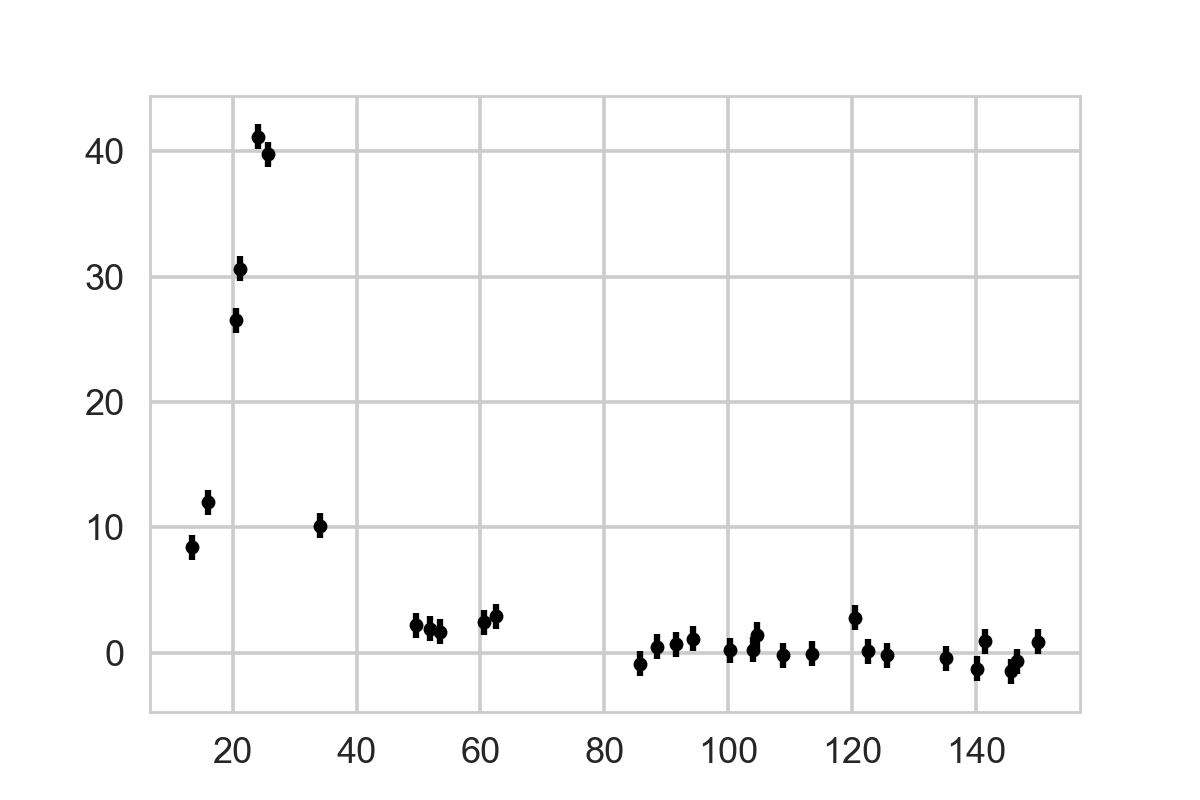

<ErrorbarContainer object of 3 artists>

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(df["grams"], df["prod"], yerr=df["prod_err"], fmt="o", markersize=5, color="black")

## A single person

Let's calculate the chocolate consumption for a single person. This is drawn from a Lorentzian function,

$$
L(x) = \frac{A}{\pi} \frac{\gamma/2}{(x-x_0)^2 + (\gamma/2)^2}
$$

where $A$ is the amplitude, $x_0$ is the centre of the Lorentzian, and $\gamma$ is the width parameter. A Lorentzian is essentially a Gaussian with broader wings, which I chose here because I didn't want to overuse the Gaussian, which will appear in several other places already.

**Caution**: By default, this function is normalized so that the integral of the Lorentzian integrates to 1. In order to make the amplitude correspond to the number of lines written, you need to multiply it by $\pi \gamma/2$!

Let's write a function to make a Lorentzian

In [ ]:
def lorentzian(x, amp, x0, gamma):
    ## add your code here
    

Let's make an example:

In [ ]:
x = np.linspace(0, 5, 1000)

x0 = 2.5
gamma = 0.5
amp = 1.0

ll = lorentzian(x, amp, x0, gamma)

Plot the result:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(x, ll, lw=2, color="black")

I hope that looks like a Lorentzian. :)

## Parameter Inference for a single person

Let's now do parameter inference for a single person.

We're going to need to define the likelihood and some priors.

For the likelihood, we're going to assume Gaussian uncertainties, so a Gaussian likelihood, defined as:

$$
\mathcal{L}(\theta) = \prod_{i=1}{N}\left[\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left(-\frac{(y_i - f(x_i, \theta))^2}{2\sigma_i^2} \right)}   \right]
$$

where $\theta = \{A, x_0, \gamma \}$ is the set of parameters, $f(x_i, \theta)$ is the model function (i.e. the Lorentzian, $\sigma_i$ is the uncertainty in the measurement $y_i$.

**Exercise 1**: Write down the probabilistic graphical model for this problem.


**Exercise 2**: Now define the likelihood for your model in a function or class.

**Hints**:
* You'll want to implement the *logarithm* of the likelihood, not the likelihood itself, to avoid  numerical errors
* You might also want to check whether the value of the likelihood is finite, and if not, return -np.inf (i.e. an improbably small value), in order to avoid issues with NaNs
* Write your log-likelihood such that it takes the *logarithm* of the amplitude . Can you think of a good reason for this? Discuss with your partner!

Below, I've provided a simple structure for a likelihood class. I like writing likelihoods in classes, because it means I can call `mylikelihood(parameters)` and it will know about the data automatically! 


If you're more comfortable writing a function, just do that.

In [7]:
class GaussLogLike(object):
    
    def __init__(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr
        
        # hard-coded model for this problem,
        # but could be a parameter
        self.model = lorentzian
        
    def evaluate(self, pars, neg=False):
        """
        Evaluate the likelihood
        
        Parameters
        ----------
        pars : iterable
            The list of parameters for the Lorentzian function
            
        neg : bool
            A boolean variable. If True, return the *negative* 
            log-likelihood (useful for optimization, which are 
            minimization routines), otherwise just return the 
            log-likelihood itself
        
        """
        
        # get the parameters out of the array
        # make sure the amplitude is exponentiated
        
        
        # calculate the mean model

        
        # calculate the log-likelihood
        
        
        # this code ensures that if the likelihood 
        # is NaN, it becomes negative infinite 
        # (so really, really unlikely)
        if not np.isfinite(loglike):
            loglike = -np.inf
            
        if neg:
            return -loglike
        else:
            return loglike
        
    def __call__(self, pars, neg=False):
        """
        The __call__ method allows to call the object 
        directly after instantiation. 
        
        Example:
        >>> mylikelihood = GaussLogLike(xdata, ydata, yerrors, lorenztian)
        >>> pars = [2.0, 10.0, 3.0]
        >>> print(mylikelihood(pars))
        
        """
        return self.evaluate(pars, neg)

Let's try it with our test data. 

Note: the lines below will work this way only with the class above. 
If you've written a function, replace them with whatever you need.

In [ ]:
# instantiate the likelihood object
# using the data
llike = GaussLogLike(grams1, prod1, prod_err1)

**Exercise**: Guess some parameters based on the plot you've made of the data and print the log-likelihood for those parameters. Note the result. Then define some other parameters and try again. What do you notice? 

**Hint**: remember that we've defined our amplitude in our likelihood as the *logarithm* of the actual amplitude!

In [ ]:
# define some parameters here


# calculate the log-likelihood like so:
print(llike(my_parameters))


Ok, cool, that hopefully works. For full Bayesian inference, however, we need some priors. Based on your probabilistic graphical model above, you should have an idea what parameters you'll need to define priors for. 

**Exercise**: Discuss priors with your group! What kind of priors do you think could work for the parameters here? Are there constraints on the parameters, e.g. values they cannot be allowed to take? What assumption will those priors make about the process and your data?


Below, I've made another class, this time for the posterior. It uses the likelihood we've defined above along with some priors in order to give you a posterior.

In [ ]:
class GaussPosterior(object):
    
    def __init__(self, x, y, yerr):
        """
        This code is called when you make an object of this class.
        
        Parameters
        ----------
        x : iterable
            The x-coordinate of your data
    
        y : iterable
            The y-coordinate of your data
            
        yerr : iterable
            The uncertainties on your y-values
        
        """
        self.x = x
        self.y = y
        self.yerr = yerr
        
        # hard-coded model for this problem,
        # but could be a parameter
        self.model = lorentzian
        
        # use the likelihood definition from above in here 
        # to instantiate the likelihood
        self.loglikelihood = GaussLogLike(self.x, self.y, self.yerr)
        
        # this calls the method below, which sets the priors so we don't 
        # have to do this every time (which would be computationally expensive)
        self._set_logprior_dist()

    def _set_logprior_dist(self):
        """
        Set the distributions for the log-priors in advance to avoid overhead.
        
        Hint: the distributions in scipy.stats come in handy here
        """
        
        # here's an example of how you could define some distributions.
        # first, a normal distribution, `loc` is the mean, `scale` is the standard deviation
        # self.a_dist = scipy.stats.norm(loc=10, scale=1)
        
        # here's a uniform distribution
        # note: here, `loc` is the left edge of the distribution, `scale` the width 
        # of the non-zero interval! So the example below is nonzero between 5 and 15
        # self.b_dist = scipy.stats.uniform(loc=5, scale=10)

        # prior for the log-amplitude
        self.p_logamp = # add your definition here
        
        # prior for x0
        self.p_x0 = # add your definition here
        
        # prior for gamma
        self.p_gamma = # add your definition here
    

    def logprior(self, pars):
        """
        Calculate the logarithm of the prior, assuming you've stored scipy.stats distributions
        in `_set_logprior()` as attributes above. Uses the `logpdf` to calculate the logarithm 
        of the probability density function for each parameter.
        
        If you have defined your priors differently, you'll need to change this!
        
        """
        return self.p_logamp.logpdf(pars[0]) + self.p_x0.logpdf(pars[1]) + self.p_gamma.logpdf(pars[2])

    def logposterior(self, pars, neg=False):
        """
        Calculate the log-posterior, which is just the sum of the log-prior and 
        the log-likelihood for the parameters.
        
        We play the same game as in the likelihood above: if the log-posterior 
        isn't finite, make it infinitely unlikely (-infinity), and return the 
        *negative* log-posterior if `neg=True`
        
        """
        lpost = self.loglikelihood(pars, neg=False) + self.logprior(pars)
        
        if not np.isfinite(lpost):
            lpost = -np.inf

        if neg: 
            return -lpost
        else:
            return lpost
    
    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg)

Again, let's try it:

In [ ]:
lpost = GaussPosterior(grams1, prod1, prod_err1)

**Exercise**: Print the posterior for the same range of parameters as above. Have things changed?

### Maximum-A-Posteriori Fits

One useful thing to do is optimize the log-posterior. This is the Bayesian version of maximum likelihood fitting, which you may have heard of, but now includes the information added by the prior.

In python we can use `scipy.optimize` for this.

**Hint**: Be aware that optimization routines are generally *minimization* routines. So instead of maximizing the posterior, we need to minimize the negative posterior. This is why we added a `neg` keyword to our class:

In [ ]:
import scipy.optimize

In [ ]:
res = scipy.optimize.minimize(lpost, true_pars1_log+1, method="L-BFGS-B", args=(True))

You should print out `res.message`, because it'll tell you whether the algorithm has failed. Optimization can in general be quite difficult, and you can fall into many different pitfalls. In particular, they are prone to get stuck in *local* minima, i.e. you think you've converged to the actual minimum, but you're stuck somewhere away from it in parameter space. Sometimes, what can help with this is to run the optimizer several times with different starting parameters. You can also try to use a different optimization algorithm, since different algorithms work differently well for different problems.

In any case, you should print out `res.message`, which will give you *some* information about whether your optimization was successful:

The best-fit parameters are stored in `res.x`. You should print those, too.

**Exercise**: Plot your data with the best-fit model shown in the same figure. Remember that your amplitude in the best-fit parameters is the *logarithm* of the parameter that goes into your `lorentzian` function!

Hopefully, your fit should go through most of the data points. If not, maybe try again with a different set of starting parameters.

### MCMC

A point estimate of your "best-fit" parameters is often not super helpful in learning something useful about your problem. For doing inference, we often want to know the full posterior probability density, which is, for most practical purposes, impossible to calculate analytically.

In the lecture yesterday, you've learned about MCMC. MCMC is used to *sample* the posterior in order to map out the posterior distribution efficiently. This is not an MCMC tutorial (but a nice one can be found [here](https://github.com/davidwhogg/mcmc)).

If you have the time, I'd really recommend writing your own [Metropolis-Hastings sampler](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm). It takes a while, and can be a bit fiddly, but it is super instructive! Writing your own sampler will teach you more about MCMC than any tutorial ever will!

There are many, many different types of sampling algorithms out there. Some (non-exhaustive) keywords for you to explore:

* ensemble MCMC
* simulated annealing/parallel tempering
* nested sampling (and variants diffusive nested sampling and dynamical nested sampling)
* slice sampling
* Hamiltonian Monte Carlo
* Sequential Monte Carlo

Much like with optimization algorithms, different MCMC algorithms solve different problems differently well, and how well one does might also depend on the time you can spend. A very well-tuned Metropolis-Hastings sampler might work better for you than a general ensemble MCMC method. Note that there are problems that are hard for *all* samplers. One problem is, for example, a posterior with very narrow, well-separated peaks. Finding all of those peaks is very hard no matter what algorithm you use.

Here, right now, we're not going to do this; we are going to use a fairly robust MCMC package called `emcee` to do some inference on our posterior probability density.

Most MCMC samplers need to be *initialized* in some way, that is, you need to give them the parameter values where the chain should start. We're going to use the results of the optimization earlier as an initialization. This can make your convergence faster if you're reasonably sure that your optimizer isn't super far off the actual peak of the posterior.

We're going to initialize our MCMC chains (there'll be several) using a *multi-variate normal distribution*, using the best-fit values and the covariance from the optimizer:

In [ ]:
p_opt = # add code for the best-fit parameters

The covariance is stored as `hess_inv` (inverse Hessian) in the `res` object, but in a sparse matrix format, so we'll need to convert it to an actual array:

In [ ]:
cov = res.hess_inv.todense()

In emcee, the chains are generally called *walkers*. We'll use 36, and we'll run for 1000 iterations.
Before that, however, we need to *burn in* our chains, i.e. run it for a while and hope that at the end of this *burn-in period*, our walkers have converged to the true posterior. Since this is a fairly simple problem with just three parameters, we'll try 2000 steps. In practice, we never know whether this is true, though there are some statistics you can use to explore this. 

One method is to look at the *autocorrelation time*, the number of steps you need to go until you reach an uncorrelated sample. If this time is very small, then almost all samples are uncorrelated, and your chains are doing a random walk through parameter space (and not sample the actual posterior). If the autocorrelation time is very large, then your chains are stuck somewhere and aren't actually moving about parameter space at all, and you're not converged, either.

Another method to assess convergence is the Gelman-Rubin statistic, which you can find in [this book](http://www.stat.columbia.edu/~gelman/book/) (which is generally an excellent reference to have, though not really a starting point for beginners), or alternatively also in the documentation of [this package](https://pymc-devs.github.io/pymc/modelchecking.html). 


In [ ]:
nwalkers = # number of walkers
burnin =  # number of samples for burn-in
niter =  # number of samples in production

ndim = 3 # the number of parameters

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)


Now we need to draw starting positions from a multivariate normal distribution. As we've said above, we'll take the mean and the covariance from the optimization, and we'll need to draw one for each walker:

In [ ]:
p0 = # starting positions for the walkers

Now we're set up to run the MCMC sampler:

In [ ]:
pos, prob, rstate1 = sampler.run_mcmc(p0, burnin)

One helpful diagnostic before calculating anything is to make what's called a *trace plot*. In this plot, you simply plot the value of each parameter for each chain as a function of the iterations. 

If your chains are converged, they should look like white noise (i.e. randomly distributed around a mean value). If there are significant trends, or parts where the chains look completely flat, they're likely not converged and you should run longer!

In [ ]:
for i in range(ndim):
    
    # plot a time series of each parameter versus iterations
    # hint: the quantity you want to plot is sampler.chain[:,:,i].T


If your chains don't look converged, run longer!

If they have, we're going to throw away the samples we've drawn so far, but keep the last position where the sampler has been in order to initialize our production run:

In [ ]:
sampler.reset()

In [ ]:
pos, prob, rstate1 = sampler.run_mcmc(pos, niter, rstate0=rstate1)

Plot a trace of the walkers again, using the same code as above:

Another useful plot to make once you think you have a reasonably good sample from the posterior is a so-called corner plot or pair plot, which plots the histogram of the marginal distribution for each parameter on the diagonal, and a scatter plot (or kernel density estimate) of each parameter versus each other parameter on the off-diagonal. This can help get an idea of what the posterior looks like (since we're generally not great at visualizing multi-dimensional surfaces in our head).

A nice version of this kind of plot is implemented in seaborn's [pairplot](https://seaborn.pydata.org/examples/scatterplot_matrix.html). Another nice version is implemented in the package `corner`, which you should have installed above:

In [ ]:
# concatenate the chains from all the walkers together
flatchain = sampler.flatchain.T

before plotting, exponentiate the amplitude so that we plot the amplitude itself rather than the log-amplitude:

In [ ]:
flatchain_exp = # exponentiate the amplitude

In [ ]:
corner.corner(flatchain_exp);

Okay, so this gives me a single distribution for a single person.

## Inferring Population Parameters (With Probabilistic Programming)

I have not done this experiment alone, of course! I got all my colleagues in on the game, and made them all eat chocolate and record their productivity for a month (again, not really, but they probabily wish I had)!

What we're really interested in is whether my chocolate consumption generalizes to other people, and whether we can make the whole institute more productive by giving everyone chocolate!

So we're interested in the values of `x0` for the entire population of our institute, and what this population looks like. We could just run MCMC for each person, and then histogram the results, but maybe we know more than that! Perhaps we know (from prior research on chocolate) that chocolate definitely causes an increase in productivity in everyone. Perhaps we also know that a human can only eat so much chocolate before getting sick. Perhaps we think that the productivity values might all cluster around the same value. We can use that prior information in order to *jointly* model all people together. 

The data for this problem is in this file:

In [9]:
df_all = pd.read_csv("chocolate_productivity.csv", index_col=0)

### Parameter Inference for the hierarchical model

In a hierarchical model, we want to learn something about the *population*, rather than any individual. In the model for a single person, we assumed that we had some prior distribution, e.g. for the peak productivity, and then inferred what the peak productivity for that one person (me) was. 

In the hierarchical model, we can't assume that everyone has the same peak productivity (some people might like chocolate more than others), but we can assume that the peak productivity parameters for each person come from some distribution (which itself may be related to some underlying physical process we're interested in, let's say the conversion rate of chocolate to brainpower). We're going to infer the *parameters* of that distribution along with the parameters of all the individual people in my sample. 

In our model for a single person, we had

$$
p(\theta | y) \propto p(y | \theta) p(\theta)
$$

where $\theta = \{\log(A), x_0, \log(\gamma)\}$. Instead of the rather uninformative flat priors on all of the parameters we've assumed above, we're going to assume that the peak productivity $x_0$ and the width $\log(\gamma)$ follow normal distributions with parameters $\alpha = \{\mu_x0, \sigma_x0, \mu_\gamma, \sigma_\gamma\}$. These parameters $\alpha$ are commonly called *hyperparameters*. Our model is getting slightly more complex, because now we have

$$
p(\theta, \alpha | y) \propto p(y | \theta) p(\theta | \alpha) p(\alpha) \; .
$$

Notice how the likelihood $p(y | \theta)$ still only depends on $\theta$ (not on $\alpha$, but $\alpha$ now controls the *prior* distribution for the parameters in $\theta$. In order to infer the parameters $\alpha$, we need to give them priors as well!

**Exercise**: Draw a probabilistic graphical model for the hierarchical problem.

We now want to learn something about the posterior probability for the parameters for each person along with the parameters for the whole population. Again, we turn to sampling to do this. There's a powerful way to do this in many places called *Gibbs sampling*, which we're not going to talk about today (but look it up! it's super useful!).

We're going to use Hamiltonian Monte Carlo instead. This sampling algorithm uses *gradients* in your probability distribution to efficiently sample the space (usually much more efficient than Metropolis-Hastings, for example). But it requires that you *can* actually calculate gradients in your problem. This is often the case (and definitely works in our example above), but if your physics model includes e.g. numerical simulations, it might not be. 

A nice introduction into Hamiltonian Monte Carlo can be found in [this paper](https://arxiv.org/abs/1701.02434). There's also a nice blog post that's a little more whimsical [here](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/).

The package we use here is `pymc3`, but there are others out there (look e.g. at [STAN](http://mc-stan.org) or [Edward](http://edwardlib.org)).

Note that STAN and Edward and PyMC3 are more than just samplers. They are packages that define *probabilistic programming grammars*, i.e. structures that make it easy to implement probabilistic models.

In [ ]:
import pymc3 as pm

Let's build a model for a single person using probabilistic programming first. This is going to be much less verbose than all the code we've written above.

First, let's extract a single person from our data frame:

In [10]:
c_data = df.loc[df.name == "Daniela"]

In [11]:
c_data = c_data.reset_index(drop=True)

Now you should extract the productivity, the corresponding grams of chocolate and the uncertainties on our productivity measurements. 

**Hint**: these probably need to be converted to numpy arrays, because pymc3 won't deal well with pandas `Series` objects:

In [ ]:
productivity = #
grams = #

prod_err = #

In [ ]:
# number of people
n_names = len(df["name_id"].unique())

If you get the error `"TypeError: can't pickle CVM objects"` when running the model below, then you've hit a well-known issue with the currently released version of `pymc3`. This is fixed in the current master branch, which you can install by uncommenting the following code (you might need to restart the notebook):

In [ ]:
#!pip3 install -U git+https://github.com/pymc-devs/pymc3.git

In [ ]:
with pm.Model() as chocolate_model:
    # first, let's define some priors
    # here's an example:
    #a = pm.Normal('alpha', mu=0, sd=1)
    
    # prior for the log-amplitude: same as in your model above
    log_amp = #
    
    # prior for the width: same as in your model above
    gamma = #
    
    # prior for the peak productivity: same as in your model above
    x0 = #

    # estimate the model for the parameters drawn
    # use the variables you've just defined above as your 
    # parameters and stick them into your Lorentzian
    
    prod_est = # calculate the model productivity based on the Lorentzian
    
    # Data likelihood: Because we're using a Gaussian likelihood, this should be a normal distribution
    # which takes the estimated productivity as mu, the uncertainties 
    # of the productivity as standard deviation, and the 
    # `observed` keyword should be set to the actual values of the productivity
    # for one person
    y_like = #

    # Inference button (TM)!
    indiv_trace = pm.sample(progressbar=True, steps=5000, chains=10, cores=4)


Let's make a dictionary with the true parameters (which, ahem, I've stored in the data array with your data). 

In [ ]:
true_pars = {"log_amp": np.log(c_data["true_amp"].unique()), 
             "x0": c_data["true_x0"].unique(), 
             "gamma": c_data["true_gamma"].unique()}

PyMC3 has an in-built method to make trace plots (and also plot the marginalized posterior distribution for each parameter). 

In [ ]:
pm.traceplot(indiv_trace, lines=true_pars);

Let's pull out just the `x0` parameter for this model, for use later:

In [ ]:
x0_indiv = indiv_trace.x0

Okay, now we can set up the hierarchical model. A nice introduction in how to set up a hierarchical model with pymc3 can be found [here](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/).

In the example above, we set e.g. the parameters of the prior for `x0` to actual *numbers*. However, in our new hierarchical model, these will be variables, too, which themselves are drawn from statistical distributions.

In our hierarchical model, the prior distribution for `x0` is actually something that tells us something interesting about how the productivity of a *population* of people changes if you give them chocolate. 

To make our lives easier, we're going to *only* consider the parameters for the distribution of `x0`, and assume we know the parameters for the prior of `log_gamma` and `log_amp`. 

First, we're going to need to manipulate our data a bit to make it work, since we're now working with the full distribution:


In [ ]:
# all productivity values for all people
productivity = 

# all uncertainties for all people
prod_err = 

# all x-values for all people
grams = 

# indices for assigning the parameters correctly, stored in `name_id`
prod_idx = np.array(df_all["name_id"])

# number of people in our population
n_names = 

Now we can set up the model similarly as above, just with additional priors for the parameters of the priors for `x0`:

In [ ]:
with pm.Model() as hierarchical_chocolate_model:
    # here's an example of how to define a random variable in PyMC3
    #a = pm.Normal('alpha', mu=0, sd=1)
    
    # prior for the log-amplitude
    log_amp = # same of before
    
    # prior for the log-width
    gamma = # same as before
    
    # we're going to use a normal distribution for the distribution
    # of x0
    # this distribution has a mean and a standard deviation
    # for which we choose a uniform distribution for the mean 
    # and a Half-Cauchy distribution (so it's positive) for the standard
    # deviation with a beta-parameter of 5
    
    mu_x0 = #
    sd_x0 = #
    
    # prior for the peak productivity
    x0 = # normal distribution using the `mu_x0` and `sd_x0` variables above for mean and std deviation

    # estimate the model for the parameters drawn
    
    # assign the parameters for the correct person to the 
    # right position in an array corresponding to *all* 
    # gram/productivity measurements
    amp_array = np.exp(log_amp[prod_idx])
    gamma_array = gamma[prod_idx]
    x0_array = x0[prod_idx]
    
    # definition of the Lorentzian
    prod_est = # model values for all pairs of grams/productivity for all people
    
    # Data likelihood: this should be a normal distribution
    # which takes the estimated productivity as mu, the uncertainties 
    # of the productivity as standard deviation, and the 
    # `observed` keyword should be set to the actual values of the productivity
    # for one person
    y_like = #

    # Inference button (TM)!
    hierarchical_trace = pm.sample(progressbar=True, steps=1000, chains=6, cores=4)



Let's make an array of the true parameters:

In [ ]:
# plot twist: the true values for the individual people in 
# our list are in the DataFrame you loaded!
true_log_amp = np.log(df_all["true_amp"].unique())
true_gamma = df_all["true_gamma"].unique()
true_x0 = df_all["true_x0"].unique()

# These are the true values of the distribution of 
# peak productivities I didn't tell you about!
true_mu_x0 = 25.0
true_sd_x0 = 1.0

true_pars = {"log_amp": true_log_amp, "gamma":true_gamma,
             "x0": true_x0, "mu_x0":true_mu_x0, "sd_x0": true_sd_x0}

And now we can make a trace-plot of all of the parameters with their true values:

In [ ]:
pm.traceplot(hierarchical_trace, lines=true_pars);

Let's also extract the `x0` for the first person from here:

In [ ]:
x0_hier = hierarchical_trace.x0[:,0]

Now we can compare the marginalized posterior of `x0` from the single-person model to the marginalized posterior of `x0` for the hierarchical model.

Plot the two distributions and compare.

**Hint**: The seaborn function [`distplot`](https://seaborn.pydata.org/examples/distplot_options.html) allows you to display this kind of data in several different ways. I personally like the combination of a histogram and a kernel density estimate.

You should now see two things from your trace plots and your histogram of `x0` for one person: one, we did pretty well at determining the population parameters themselves. Secondly, in the plot above, you should see that the posterior for `x0` shrunk (I hope?) in the hierarchical model compared to the model where we only had one person. This is called *Bayesian shrinkage*, and happens because the population now informs the posterior for our individual members.